In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [4]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='zmean')(x)
z_log_var = layers.Dense(latent_dim, name='zlogvar')(x)
encoder = keras.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_1[0][0]']               
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_2[0][0]']               
                                                                                            

In [15]:
#Code to generate LS point z

class Sampler(layers.Layer):
  def call(self, z_mean, z_log_var):
    batch_size = tf.shape(z_mean)[0]
    z_size = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch_size, z_size))
    return z_mean + tf.exp(0.5*z_log_var)*epsilon

In [7]:
#Decoder

latent_inputs = keras.Input(shape=(latent_dim, ))
x = layers.Dense(7*7*64, activation='relu')(latent_inputs)     #To produce same number of coefficients that we had at flatten layer of encoder
x = layers.Reshape((7,7,64))(x)     #To revert Flatten layer of encoder
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)    #Reverting Conv2D layers
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)    #Output ends up with shape 28, 28, 1
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 1)         289 

In [17]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.sampler = Sampler()

    #Below 3: To keep track of loss averages per epoch
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")    #Regularization is called KL loss

  @property
  def metrics(self):
    return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var = self.encoder(data)
      z = self.sampler(z_mean, z_log_var)
      reconstruction = decoder(z)
      reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2)))
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)

      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      return {
          "total_loss": self.total_loss_tracker.result(),
          "reconstruction_loss": self.reconstruction_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result(),
      }    



In [19]:
#Training VAE

import numpy as np

(xtrain, _), (xtest, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([xtrain, xtest], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32') / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam', run_eagerly=True)
vae.fit(mnist_digits, epochs=5, batch_size=128)   #We don't pass targets, since training step doesn't expect any

Epoch 1/5
547/547 [==============================] - 129s 236ms/step - total_loss: 181.0570 - reconstruction_loss: 177.4413 - kl_loss: 3.6155
Epoch 2/5
547/547 [==============================] - 129s 237ms/step - total_loss: 164.2958 - reconstruction_loss: 160.4175 - kl_loss: 3.8781
Epoch 3/5
547/547 [==============================] - 129s 235ms/step - total_loss: 159.5175 - reconstruction_loss: 155.5905 - kl_loss: 3.9270
Epoch 4/5
547/547 [==============================] - 130s 238ms/step - total_loss: 156.6425 - reconstruction_loss: 152.7034 - kl_loss: 3.9390
Epoch 5/5
547/547 [==============================] - 145s 265ms/step - total_loss: 154.9260 - reconstruction_loss: 150.9963 - kl_loss: 3.9297


In [21]:
#Sampling grid of images form 2d latent space

import matplotlib.pyplot as plt

n = 30            #displaying a grid of 30*30 images (900 images)
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))

#Sampling points linearly on 2D grid
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
  for j, xi in enumerate(grid_x):
    z_sample = np.array([[xi, yi]])
    x_decoded = vae.decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i*digit_size: (i+1)*digit_size, j*digit_size: (j+1)*digit_size] = digit

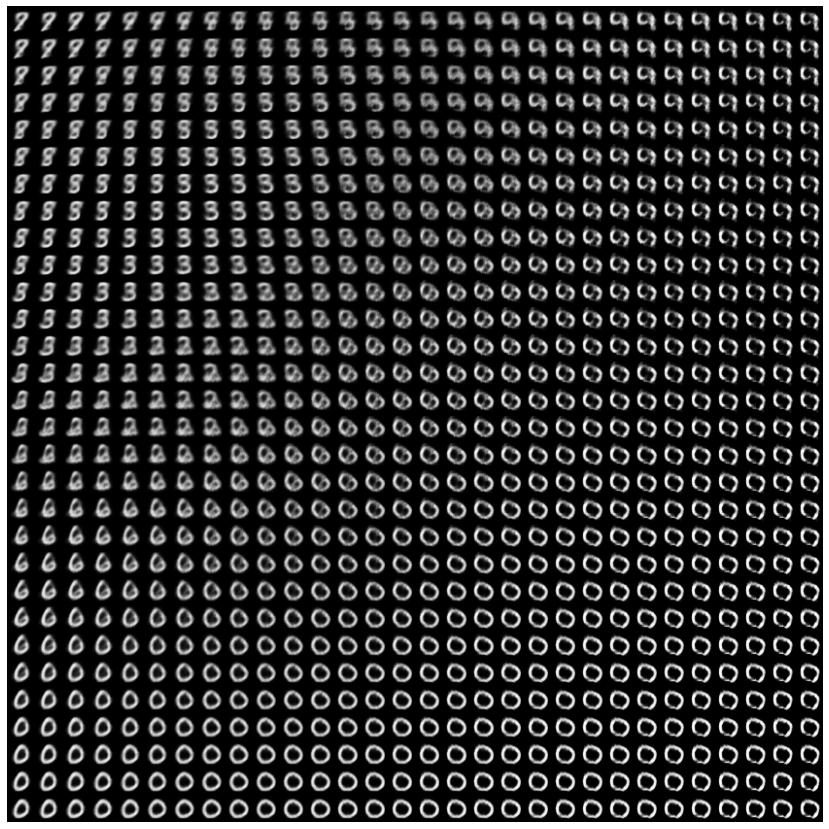

In [22]:
plt.figure(figsize=(15,15))
start_range = digit_size // 2
end_range = n*digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")